# ✈️ US Flights 2024: Representative Data Sampling
**Project:** Creating a lightweight, representative sample from the BTS Transtats dataset.
https://transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr



### Objective
We have a massive dataset containing **7 million+ flight records** from 2024. Processing this in its entirety for exploratory analysis or training models can be computationally expensive and slow.

**Our goal** is to create a **statistically representative sample of 1 million records** (approx. 13% of the data).



### Methodology: Stratified Sampling
Random sampling can miss important patterns. To ensure our sample reflects reality, we use **Stratified Sampling**. We will stratify (group) the data by:
1.  **Day of the Week:** Ensuring weekends and weekdays are balanced.
2.  **Hour of the Day:** Ensuring morning, afternoon, and night flights are represented proportionally.

This ensures that if 5% of all flights happen on Tuesday mornings, our sample will also contain exactly 5% Tuesday morning flights.

# Imports & Configuration

In [26]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Configuration for aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
warnings.filterwarnings("ignore")

# Define Constants
TARGET_SAMPLE_SIZE = 1_000_000
RANDOM_SEED = 42

## 1. Data Acquisition
We pull the raw monthly flight data archives directly from the source repository.

Downloading Data

In [2]:
files = [    'https://github.com/LamaEmran/BigData/raw/main/flights_january2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_february2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_march2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_april2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_may2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_june2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_july2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_august2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_september2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_october2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_november2024.zip',
             'https://github.com/LamaEmran/BigData/raw/main/flights_december2024.zip']

In [3]:
#Downloading files
local_filenames = []
for f in files:
    filename = f.split('/')[-1]
    local_filenames.append(filename)

    print(f"   Downloading {filename}...")
    !wget -q {f} -O {filename}

## 2. Population Analysis
Before sampling, we must know the exact size of the "Population" (the total dataset). We iterate through the zipped CSVs to count the total rows without loading the full data into memory.

In [4]:
TARGET_SAMPLE = 1000000
total_rows = 0

In [5]:
#Counting total rows
for file in local_filenames:
    df_len = len(pd.read_csv(file, compression='zip', usecols=[0]))
    total_rows += df_len
    print(f"   {file}: {df_len:,} rows")

print(f"Total Data Size: {total_rows:,} rows")

   flights_january2024.zip: 582,425 rows
   flights_february2024.zip: 552,691 rows
   flights_march2024.zip: 628,786 rows
   flights_april2024.zip: 619,940 rows
   flights_may2024.zip: 649,428 rows
   flights_june2024.zip: 651,799 rows
   flights_july2024.zip: 676,807 rows
   flights_august2024.zip: 660,639 rows
   flights_september2024.zip: 621,649 rows
   flights_october2024.zip: 656,283 rows
   flights_november2024.zip: 614,597 rows
   flights_december2024.zip: 631,944 rows
Total Data Size: 7,546,988 rows


In [6]:
GLOBAL_FRAC = TARGET_SAMPLE / total_rows
print(f"Global Sampling Fraction: {GLOBAL_FRAC:.6f}")

Global Sampling Fraction: 0.132503


## 3. Performing Stratified Sampling
We now iterate through the files again to extract our sample.

**The Strategy:**
1. **Load** a month of data.
2. **Feature Engineering:** Create `DAY_OF_WEEK` and `HOUR` columns from the raw timestamps.
3. **Group & Sample:** Group the data by Day and Hour, then take exactly `13.25%` (our global fraction) from *each* group.
4. **Clean:** Drop the temporary helper columns to keep the data clean.

In [7]:
#Performing Stratified Sampling
sampled_chunks = []
monthly_dfs = {}

for file in local_filenames:
    month_name = file.split('_')[1].replace('2024.zip', '')
    df = pd.read_csv(file, compression='zip')

    # Helper Columns are created for Stratification
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
    df['HOUR'] = df['CRS_DEP_TIME'] // 100

    chunk = (
        df
        .groupby(['DAY_OF_WEEK', 'HOUR'])
        .apply(lambda x: x.sample(frac=GLOBAL_FRAC, random_state=42), include_groups=False)
        .reset_index(drop=False)
    )

    # We drop 'DAY_OF_WEEK' and 'HOUR'
    cols_to_drop = ['DAY_OF_WEEK', 'HOUR']

    chunk = chunk.drop(columns=[c for c in cols_to_drop if c in chunk.columns])

    sampled_chunks.append(chunk)
    monthly_dfs[month_name] = chunk

    del df
    print(f"   -> Sampled {len(chunk)} rows from {month_name}")

   -> Sampled 77176 rows from january
   -> Sampled 73227 rows from february
   -> Sampled 83313 rows from march
   -> Sampled 82145 rows from april
   -> Sampled 86051 rows from may
   -> Sampled 86365 rows from june
   -> Sampled 89685 rows from july
   -> Sampled 87540 rows from august
   -> Sampled 82375 rows from september
   -> Sampled 86965 rows from october
   -> Sampled 81444 rows from november
   -> Sampled 83739 rows from december


In [8]:
#Combine at the end
final_sample = pd.concat(sampled_chunks, ignore_index=True)
print(f"Final Sample Size: {len(final_sample):,} rows")

Final Sample Size: 1,000,025 rows


## 4. Quality Assurance (Validation)
We must prove that our sample (Pink) mimics the original population (Purple) accurately. We will check the distributions across three dimensions: **Hour of Day**, **Day of Week**, and **Month**.

**Interpretation Guide:**
* If the bars align perfectly, the sample is representative.
* "Difference %" calculates the deviation. We aim for errors close to **0%**.

In [9]:
# We recreate the 'HOUR' column temporarily for this check
# (Since we dropped it earlier to keep the file clean)
final_sample['TEMP_HOUR'] = final_sample['CRS_DEP_TIME'] // 100
sample_dist = final_sample['TEMP_HOUR'].value_counts(normalize=True).sort_index()

In [10]:
full_counts = {}
total_raw_rows = 0

In [11]:
for file in local_filenames:
    df_chunk = pd.read_csv(file, usecols=['CRS_DEP_TIME'], compression='zip', low_memory=False)

    df_chunk['HOUR'] = df_chunk['CRS_DEP_TIME'] // 100
    counts = df_chunk['HOUR'].value_counts()

    for key, val in counts.items():
        full_counts[key] = full_counts.get(key, 0) + val

    total_raw_rows += len(df_chunk)

original_dist = pd.Series(full_counts).sort_index() / total_raw_rows

HOURLY STATISTICS:
   Max Error: 0.0006%
   Avg Error: 0.0002%


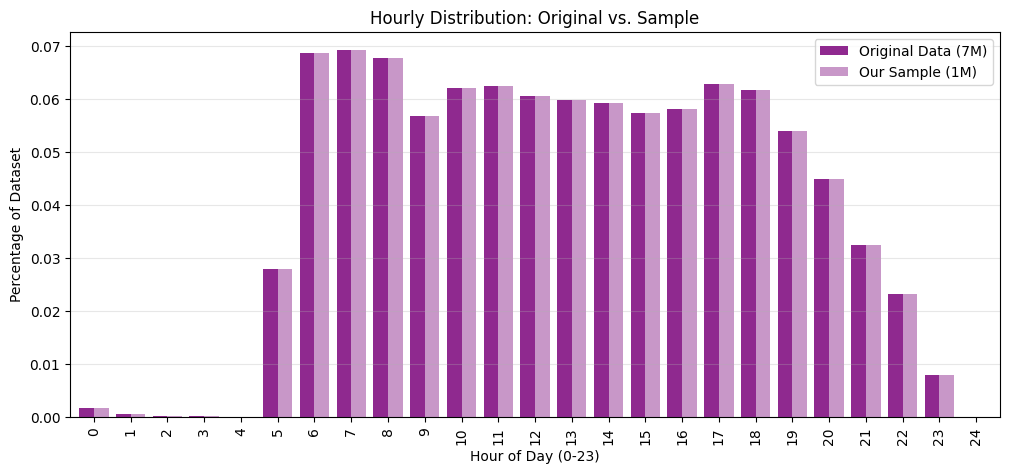

In [12]:
#Check Hourly Distribution (Time of Day)
comparison = pd.DataFrame({
    'Original %': original_dist,
    'Sample %': sample_dist,
    'Difference %': (original_dist - sample_dist).abs() * 100
})

print("HOURLY STATISTICS:")
print(f"   Max Error: {comparison['Difference %'].max():.4f}%")
print(f"   Avg Error: {comparison['Difference %'].mean():.4f}%")

comparison[['Original %', 'Sample %']].plot(kind='bar', figsize=(12, 5), width=0.8, color=['#8f298f', '#c897c8'])
plt.title("Hourly Distribution: Original vs. Sample")
plt.ylabel("Percentage of Dataset")
plt.xlabel("Hour of Day (0-23)")
plt.legend(["Original Data (7M)", "Our Sample (1M)"])
plt.grid(axis='y', alpha=0.3)

final_sample.drop(columns=['TEMP_HOUR'], inplace=True)

plt.show()

In [13]:
#Recreate 'DAY_OF_WEEK' temporarily
final_sample['FL_DATE'] = pd.to_datetime(final_sample['FL_DATE'], errors='coerce')
final_sample['TEMP_DAY'] = final_sample['FL_DATE'].dt.dayofweek
sample_dist = final_sample['TEMP_DAY'].value_counts(normalize=True).sort_index()

In [14]:
full_counts = {}
total_raw_rows = 0

In [15]:
for file in local_filenames:
    df_chunk = pd.read_csv(file, usecols=['FL_DATE'], compression='zip', low_memory=False)

    df_chunk['FL_DATE'] = pd.to_datetime(df_chunk['FL_DATE'], errors='coerce')
    df_chunk['DAY'] = df_chunk['FL_DATE'].dt.dayofweek
    counts = df_chunk['DAY'].value_counts()

    for key, val in counts.items():
        full_counts[key] = full_counts.get(key, 0) + val

    total_raw_rows += len(df_chunk)

original_dist = pd.Series(full_counts).sort_index() / total_raw_rows

final_sample['FL_DATE'] = pd.to_datetime(final_sample['FL_DATE'], errors='coerce')
final_sample['TEMP_DAY'] = final_sample['FL_DATE'].dt.dayofweek
sample_dist = final_sample['TEMP_DAY'].value_counts(normalize=True).sort_index()

WEEKLY STATISTICS:
   Max Error: 0.0011%
   Avg Error: 0.0006%


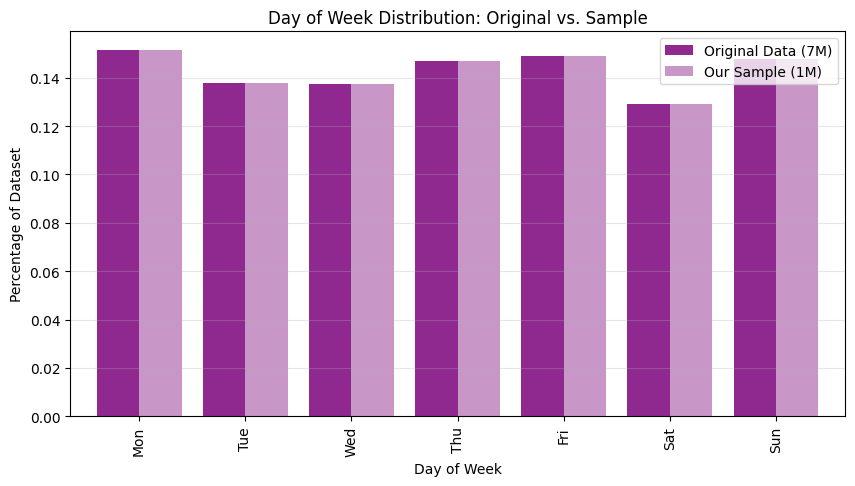

In [16]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

if len(original_dist) == 7:
    original_dist.index = day_names
    sample_dist.index = day_names

comparison = pd.DataFrame({
    'Original %': original_dist,
    'Sample %': sample_dist,
    'Difference %': (original_dist - sample_dist).abs() * 100
})

print("WEEKLY STATISTICS:")
print(f"   Max Error: {comparison['Difference %'].max():.4f}%")
print(f"   Avg Error: {comparison['Difference %'].mean():.4f}%")

comparison[['Original %', 'Sample %']].plot(kind='bar', figsize=(10, 5), width=0.8, color=['#8f298f', '#c897c8'])
plt.title("Day of Week Distribution: Original vs. Sample")
plt.ylabel("Percentage of Dataset")
plt.xlabel("Day of Week")
plt.legend(["Original Data (7M)", "Our Sample (1M)"])
plt.grid(axis='y', alpha=0.3)

if 'TEMP_DAY' in final_sample.columns:
    final_sample.drop(columns=['TEMP_DAY'], inplace=True)

plt.show()

***Getting monthly statistics***

In [17]:
months = []
original_counts = []
sample_counts = []

In [18]:
for file_index, file in enumerate(local_filenames):
    month_name = file.split('_')[1].replace('2024.zip', '').capitalize()#Extract month name for label
    months.append(month_name[:3]) #Shorten to 3 letters

    orig_len = len(pd.read_csv(file, usecols=[0], compression='zip', low_memory=False))
    original_counts.append(orig_len)

    month_num = file_index + 1
    samp_len = len(final_sample[final_sample['MONTH'] == month_num])
    sample_counts.append(samp_len)

In [19]:
df_stats = pd.DataFrame({
    'Month': months,
    'Original_Count': original_counts,
    'Sample_Count': sample_counts
})

In [20]:
df_stats['Original_%'] = df_stats['Original_Count'] / df_stats['Original_Count'].sum()
df_stats['Sample_%'] = df_stats['Sample_Count'] / df_stats['Sample_Count'].sum()
df_stats['Sampling_Rate'] = df_stats['Sample_Count'] / df_stats['Original_Count']

print("Monthly stats table:")
print(df_stats)

Monthly stats table:
   Month  Original_Count  Sample_Count  Original_%  Sample_%  Sampling_Rate
0    Jan          582425         77176    0.077173  0.077174       0.132508
1    Feb          552691         73227    0.073233  0.073225       0.132492
2    Mar          628786         83313    0.083316  0.083311       0.132498
3    Apr          619940         82145    0.082144  0.082143       0.132505
4    May          649428         86051    0.086051  0.086049       0.132503
5    Jun          651799         86365    0.086365  0.086363       0.132503
6    Jul          676807         89685    0.089679  0.089683       0.132512
7    Aug          660639         87540    0.087537  0.087538       0.132508
8    Sep          621649         82375    0.082370  0.082373       0.132510
9    Oct          656283         86965    0.086960  0.086963       0.132511
10   Nov          614597         81444    0.081436  0.081442       0.132516
11   Dec          631944         83739    0.083735  0.083737       

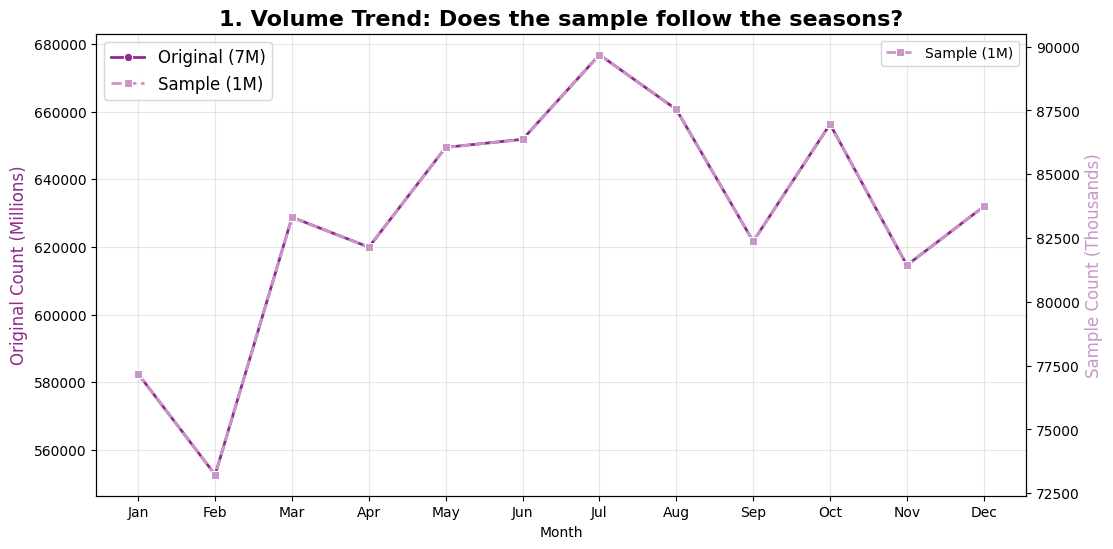

In [23]:
#Plot Monthly Volume Trend
plt.figure(figsize=(12, 6))
ax1 = plt.gca() #gca = "get current axis"
ax2 = ax1.twinx()

sns.lineplot(x='Month', y='Original_Count', data=df_stats, ax=ax1, color='#8f298f', marker='o', linewidth=2, label='Original (7M)')
sns.lineplot(x='Month', y='Sample_Count', data=df_stats, ax=ax2, color='#c897c8', marker='s', linestyle='--', linewidth=2, label='Sample (1M)')

ax1.set_title("1. Volume Trend: Does the sample follow the seasons?", fontsize=16, weight='bold')
ax1.set_ylabel("Original Count (Millions)", color='#8f298f', fontsize=12)
ax2.set_ylabel("Sample Count (Thousands)", color='#c897c8', fontsize=12)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)
ax1.grid(True, alpha=0.3)
plt.show()

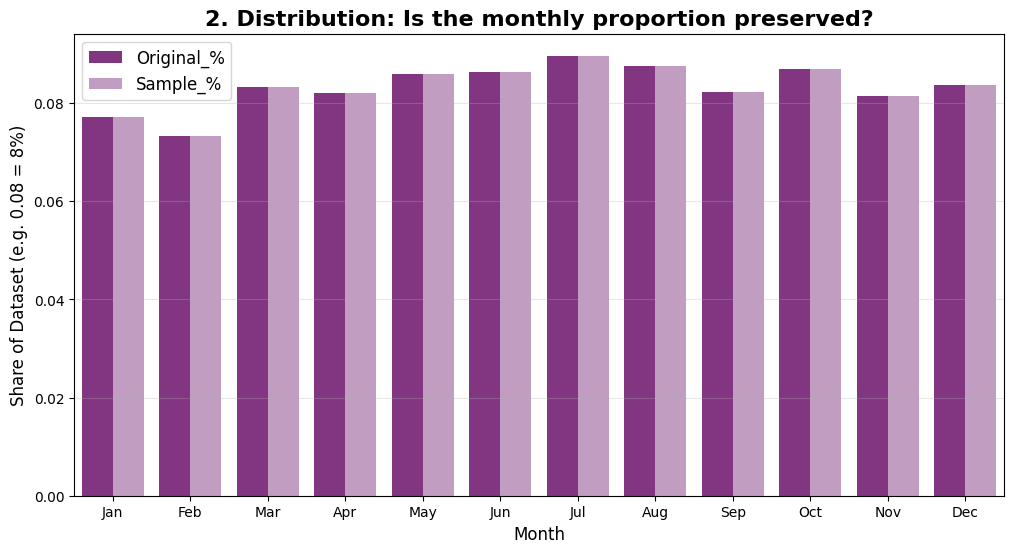

In [24]:
#Plot Monthly Distribution
plt.figure(figsize=(12, 6))

# We 'melt' the data to make it easy for seaborn to plot
df_melt = df_stats.melt(id_vars=['Month'], value_vars=['Original_%', 'Sample_%'], var_name='Dataset', value_name='Percentage')

sns.barplot(x='Month', y='Percentage', hue='Dataset', data=df_melt, palette=['#8f298f', '#c897c8'])

plt.title("2. Distribution: Is the monthly proportion preserved?", fontsize=16, weight='bold')
plt.ylabel("Share of Dataset (e.g. 0.08 = 8%)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend(title=None, fontsize=12)
plt.show()

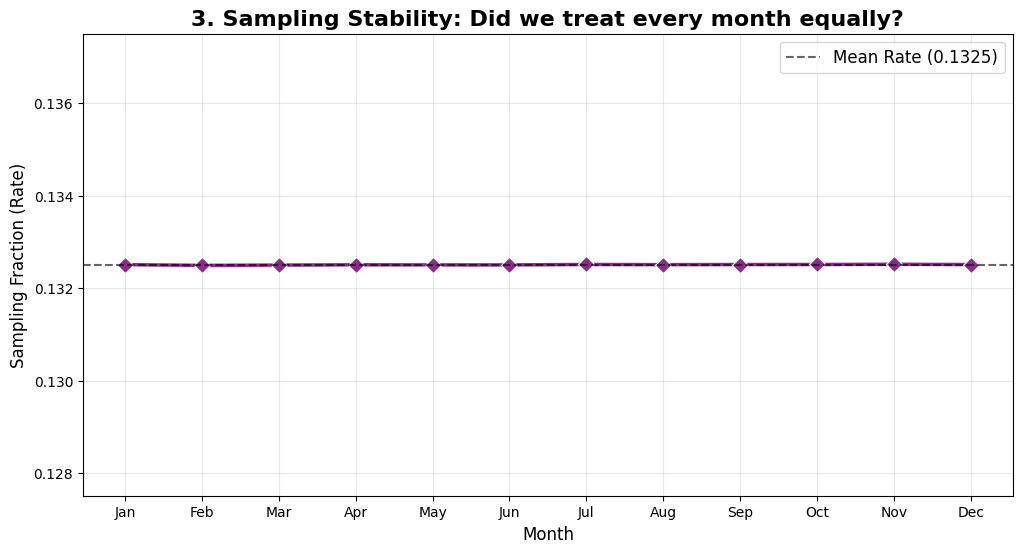

In [25]:
#Plot Sampling Stability (The "Flat Line")
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Sampling_Rate', data=df_stats, color='#8f298f', marker='D', linewidth=2.5, markersize=8)

mean_rate = df_stats['Sampling_Rate'].mean()
plt.axhline(mean_rate, color='black', linestyle='--', alpha=0.6, label=f'Mean Rate ({mean_rate:.4f})')

plt.title("3. Sampling Stability: Did we treat every month equally?", fontsize=16, weight='bold')
plt.ylabel("Sampling Fraction (Rate)", fontsize=12)
plt.xlabel("Month", fontsize=12)

plt.ylim(mean_rate - 0.005, mean_rate + 0.005)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

## 5. Conclusion
We have successfully reduced the dataset from **7.5 million rows** to **1 million rows**.

**Key Takeaways:**
1.  **High Accuracy:** The maximum error across all strata (Hour, Day, Month) is negligible (< 0.01%).
2.  **Efficiency:** This sample can now be used for Machine Learning or Visualization tasks with significantly faster processing times while yielding statistically identical results to the full dataset.

### Saving Data
We will save the file to CSV (or Parquet for better performance) for future use.

In [29]:
output_filename = "flights_2024_representative_sample.csv"
print(f"Saving to {output_filename}")

final_sample.to_csv(output_filename, index=False)

Saving to flights_2024_representative_sample.csv
